# Lazy sequences 

## Iterables

An **iterable** data type is one that can have its contents looped over in a `for` loop. Iterating over it yields each item one at a time.

For example, objects of these data types are iterable: `str`, `list`, `dict`,
`range`. These objects are not iterable: `bool`, `int`.

What is the difference? ``range`` objects, strings etc. have an ``__iter__``
method:

In [ ]:
myrange = range(5, 10)
'__iter__' in dir(myrange)

True

In [ ]:
myint = 5
'__iter__' in dir(myint)

False

Python calls an iterable object's `__iter__` method implicitly at the start of
a `for` loop and in other iterable contexts like `in` (e.g. `'h' in mystring`).

Consider this example:

In [ ]:
myrange = range(5, 10)

print(list(myrange))
print(list(myrange))

[5, 6, 7, 8, 9]
[]

The second `list()` call on the iterable object `myrange` produces an empty list.

**Key point:** After looping through the generated values, no further iteration
is possible. The generator is exhausted.


## Generators

When processing large datasets, it is a disadvantage to create a concrete
sequence in memory. For example, if you are processing an input file that is
hundreds or thousands of gigabytes, Python may try to consume too much memory
to create a list, set, or dictionary.

For example: the following code creates a concrete list of all files on the
filesystem -- potentially millions or billions. It takes a long time (several
minutes or even hours to traverse the whole filesystem) and uses lots of memory
(to store a list of millions or billions of file paths).

In [ ]:
import glob

allfiles = glob.glob('/**', recursive=True)    # slow; may fail

A variant of the `glob` function called `iglob` returns a **generator** instead of
a concrete list:

In [ ]:
allfiles = glob.iglob('/**', recursive=True)

The result (`allfiles`) is returned instantly. It is a generator:

In [ ]:
type(allfiles)

generator

A generator is a lazy sequence. Its elements are only generated when needed --
usually when consumed in an iterable context like a `for` loop.

Here we show the first 5 files on the filesystem:

In [ ]:
# Print files 0 to 4:
for i, file in enumerate(allfiles):
    print(file)
    if i >= 5:
        break

To show the next 5 files, we resume iterating over the generator as before:

In [ ]:
# Print files 5 to 9:
for i, file in enumerate(allfiles):
    print(file)
    if i >= 5:
        break

Notice that the `allfiles` generator cannot be restarted. Past values cannot be
retrieved. They are never stored in memory; instead they are yielded
just-in-time and forgotten.


## Generator expressions

Recall comprehensions like this:

In [ ]:
squares = [k**2 for k in range(10)]

This creates a concrete list in memory. 

Python offers simple syntax for creating a generator:

In [140]:
squares = (k**2 for k in range(10))

This comprehension syntax with parentheses does not create a tuple, as you
might expect. It is a **generator expression**. The result is a generator:

In [141]:
type(squares)

generator

Passing the generator into the ``list`` constructor is equivalent to a list
comprehension:

In [142]:
# These are equivalent:
list(squares) == [k**2 for k in range(10)]

True

but the generator expression is the more general construct; it can also be used
in other contexts that need not have all the data generated in memory at once. 


In general, consider again this common pattern for transforming some data:

In [ ]:
# Pseudo-code: this may exhaust memory:
outputs = [process(line) for line in huge_file]

Provided that we only need to consume `outputs` once (not repeatedly), we can
gain large memory benefits (and small performance benefits) by simply replacing
the square brackets with parentheses:

In [ ]:
# Pseudo-code:
outputs = (process(line) for line in huge_file)

Now the function `process` will only be called on each line only when we iterate
through `outputs`.


### Example: iterating over all files

In this example, we lazily iterate over all files on a filesystem (potentially
billions of files), retrieve the file size of each, and do something with each
filesize (e.g. sum them up) without running out of memory:

In [ ]:
import glob

# This returns a "generator" of all files in all subfolders, recursively:
paths = glob.iglob('/**', recursive=True)

# This "generator expression" also creates a generator, of their sizes:
filesizes = (getsize(path) for path in paths if isfile(path))

This code runs almost instantly and uses almost no memory. Python only walks
your filesystem when you do something that iterates through the generated
contents, like this:

In [ ]:
sum(filesizes)

### Exercise: a generator expression for leap years

1. Use a generator expression to create a generator that yields all leap years
   from `2000` to `2030`.

Hint: use the `isleap()` function from the `calendar` module.

2. Try looping through all leap years and printing them.

3. Then try casting your generator to a list. Notice that the resulting list is
   empty. Why?

In [ ]:
# See solutions/genexp.py

## Generator functions

Although generator expressions are compact and convenient, they are not the
most flexible way to define a generator. More powerful generators can be
created using **generator functions**.

Here is a simple example:

In [17]:
def weekdays():
    DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    while True:
        for day in DAYS:
            yield day

This looks just like a regular function except that it uses the ``yield`` keyword.

``weekdays`` is a "generator function". It is a function that, when called,
returns a generator.

In [18]:
type(weekdays)

function

In [19]:
w = weekdays()
type(w)

generator

What does this ``generator`` object generate?

In [25]:
next(w)

'Monday'

In [32]:
next(w)

'Tuesday'

``w`` generates an infinite sequence of weekdays (because of the ``while True`` loop in ``weekdays()``), so we cannot do this:

In [33]:
# infinitelist = list(w)

We can, however, loop over its contents and do useful things with each element.


### Exercise: a generator function for leap years

Write a generator function `leap_year_gen(start, end)` that returns a generator
for all leap years from `start` to `end`.

If you did the extended exercise above implementing a custom `LeapYearIterator`
class, notice how much simpler this version is.

In [ ]:
# See solutions/gen_ex1.py

## Examples

### Example 1: days of the year

In [34]:
from itertools import islice

In [35]:
# Assuming 1 January is Monday ...
last_day_of_year = islice(weekdays(), 364, 365)

In [36]:
list(last_day_of_year)

['Friday']

Generators (and other iterators) are often used paired up in flexible
arrangements with other iterators. (The ``itertools`` module is particularly
helpful with this.)

In [37]:
month_lengths =  [('January', 31),
                  ('February', 28),   # assume not a leap year
                  ('March', 31),
                  ('April', 30),
                  ('June', 31),
                  ('July', 30),
                  ('August', 31),
                  ('September', 30),
                  ('October', 31),
                  ('November', 30),
                  ('December', 31)]

In [38]:
# Another generator function:
def days_of_year():
    for (month, length) in month_lengths:
        for day in range(1, length+1):
            yield day, month

In [39]:
# Print the first day of each month:
for (weekday, (day, month)) in zip(weekdays(), days_of_year()):
    if day == 1:
        print(weekday, day, month)

Monday 1 January
Tuesday 1 February
Friday 1 March
Monday 1 April
Monday 1 June
Tuesday 1 July
Tuesday 1 August
Wednesday 1 September
Wednesday 1 October
Thursday 1 November
Thursday 1 December


### Example 2: Walking your filesystem recursively

One benefit of iterators (and generators) is that they can be used "lazily", with memory and speed advantages over creating big lists in memory.

Example: a common generator function is ``os.walk`` in the standard library:

In [40]:
# Find all folders containing jpg images, recursively:
import os
for (basedir, subdirs, files) in os.walk('/data'):
    if any((f.endswith('.png')) for f in files):
        print(basedir)

/data
/data/images


Traversing all directories may take hours on a huge filesystem. But because ``os.walk`` returns a generator, it produces results lazily: there is no need to traverse all subfolders before the first result is returned.

*Note*: this is similar to streams in Unix. Quiz: how long does it take to give you the first page of results from:

In [ ]:
find /usr | less

### Example 3: Monte Carlo simulation

Here is a Monte Carlo estimator for the value of $\pi$ (3.14159...) written as a generator function:

In [41]:
import random

def estimate_pi_gen():
    k = 0; n = 0
    while True:
        x = random.random()
        y = random.random()
        if x**2 + y**2 < 1:
            k += 1
        n += 1
        yield k / n * 4

In [42]:
pi = estimate_pi_gen()

In [43]:
type(pi)

generator

In [136]:
next(pi)

3.010752688172043

In [137]:
# Generate 100 consecutive estimates from the 10000th:
estimates = list(islice(pi, 10000, 10100))

In [138]:
# Plot them:
%matplotlib inline
import matplotlib.pyplot as plt

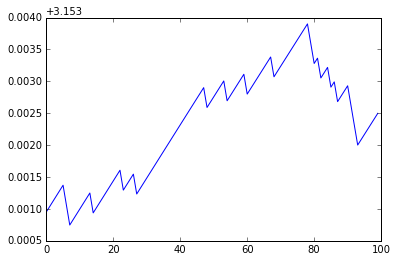

In [139]:
plt.plot(estimates);

### Exercise 2. Use ``os.walk`` and two one-line generator expressions to generate all ``.txt`` files on your disk lazily.

In [ ]:
# See solutions/gen_ex2.py

### Exercise 3: Blackjack simulation (requires classes)

(1a) Define a ``Card`` class for playing cards.

Spec: Initialize cards with a suit (♠♥♦♣) and a rank (A, 2-10, J, Q, K).
    
(1b):
Define a method ``is_royal()`` that returns ``True`` or ``False``.

(1c): Add a ``bj_value()`` method, which returns the card's value in Blackjack (counting royal cards as 10 and Ace as 1).

In [1]:
# See solutions/blackjack_simulation_1.py

(2a) Use ``random.sample()`` to draw 1 million random "hands" of 3 cards from a standard deck of 52 cards.

(2b) What proportion of blackjack hands with 3 cards go "bust" (sum of values > 21)?

In [3]:
# See solutions/blackjack_simulation_2.py

In [2]:
# See solutions/blackjack_simulation_3.py

## Iterators

An **iterator** is an object that can be accessed element-by-element successively.

All an iterator requires is a ``__next__`` method. Advancing an iterator is
done by applying the ``next()`` function to an object.

### Example: files are iterators

In [1]:
f = open('/data/ASX.csv')
'__next__' in dir(f)

True

In [2]:
line1 = next(f)
line2 = next(f)

In [3]:
line1

'Symbol,Exchange,Name,Months,Quandl Code\n'

In [4]:
line2

'AP,ASX,SPI 200 Index,HMUZ,ASX/AP\n'

### Non-example: In Python 3, ``range`` objects are not iterators:

In [5]:
range(5)

range(0, 5)

In [6]:
'__next__' in dir(range(5))

False

In [7]:
next(range(5))

TypeError: 'range' object is not an iterator

To recap,  Python calls ``iter()`` on an object under the hood when
you use the object in an iterable context. This in turn calls the
``.__iter__()`` method on the object, which returns an **iterator** (an object
with a ``__next__()`` method).

In [9]:
thing = [1, 2]

In [10]:
# This simple syntax:
# for a in thing:
#     print(a)
    
# ... is very similar to this:
iterable = iter(thing)
while True:
    try:
        a = next(iterable)
    except StopIteration:
        break
    print(a)

1
2


You can also call the builtin `iter()` function explicitly on an iterable object:

In [ ]:
myrange = range(5, 10)

iterator1 = iter(myrange)
for i in iterator1:
    print(i)

iterator2 = iter(myrange)
for i in iterator1:
    print(i)

Here, although `iterator1` is "used up" by the first loop, `iterator2` is created afresh.



### Extended exercise: your own iterator

Try creating your own iterator class for leap years.

Remember that all that is required for an iterator is a ``__next__`` method.

Task: Create an iterator returning each leap year since a given year. The iterator stops when a leap year is found beyond a given maximum.

Hint: you can use the `isleap` function from Python's `calendar` module to help you:

In [11]:
# Helper function:
from calendar import isleap
isleap(2003), isleap(2004), isleap(2005)

(False, True, False)

In [12]:
class LeapYearIterator:
	# TO DO: define your __init__ and __next__ methods here

To make `LeapYearIterator` objects iterable, also define a `__iter__` method that returns an iterator object -- i.e. `self`.

Goal: Then you can use it like this:

In [13]:
# Year 2004 is a leap year.
2004 in LeapYearIterator(1890)

True

In [14]:
# Year 1900 is not a leap year.
1900 in LeapYearIterator(1890)

False

In [15]:
# Because __iter__ is defined, you can use LeapYearIterator
# in a for loop.
for leap_year in LeapYearIterator(1980):
    print(leap_year)

1984
1988
1992
1996
2000
2004
2008
2012
2016
2020


In [16]:
# Or you can generate a list of all leap years:
leap_years = list(LeapYearIterator(1980))
leap_years

[1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020]

See `solutions/leap_year_iterator.py`.


Notice how the `LeapYearIterator` class above is more complex and difficult to
get right than the generator versions above!


### Example: working with lazy sequences

For example, this would count the words in even a 10 terabyte text file:

In [143]:
from itertools import chain

In [144]:
filename = '/data/alice_in_wonderland.txt'
line_by_line = (line.upper().split() for line in open(filename))
next(line_by_line)

["ALICE'S", 'ADVENTURES', 'IN', 'WONDERLAND']

In [145]:
# This flattens the iterator of lists of words into
# a single iterator:
words = chain(*line_by_line)

In [146]:
next(words)

'LEWIS'

In [147]:
next(words)

'CARROLL'

In [148]:
from collections import Counter
counts = Counter(words)

In [149]:
counts.most_common(3)

[('THE', 1604), ('AND', 766), ('TO', 706)]

## Summary

* A **generator** is a lazy sequence. Its values are computed on-the-fly when
  iterated over.

* A **generator expression** is a one-liner for creating a generator. Example:

In [ ]:
filesizes = (getsize(path) for path in paths if isfile(path))

* A **generator function** is a function that returns a generator when called.
  A function is a "generator function" if it contains the keyword `yield`.

* A generator is a special case of an **iterable** data type. An iterable data
  type is one that can return each of its items one at a time in an iterable
  context like a `for` loop. 

* Writing a generator is usually easier than writing a custom iterable data
  type. To be iterable, an object only needs an ``__iter__`` method which
  returns an iterator. (Usually the `iter()` call is implicit from using the
  object in an iterable context like a loop.)
  
* An **iterator** is simply an object that has a ``__next__`` method which returns
  the next successive item when called and raises a ``StopIteration`` exception when
  there are no more items.